In [1]:
! pip install Evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 628.1 kB/s eta 0:00:00a 0:00:01


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import evaluate

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


## EDA of cnn_dailymail

In [3]:
df_train = pd.read_csv('train.csv')
df_val = pd.read_csv('validation.csv')
df_train.sample(5)

,id,article,highlights
192537,853daf3d4faa1a5ae327afffad5165bac5802a65,"By . Sam Webb . Lee Crabtree, 27, posed as a t...",The woman set a honey trap for 27 year old dis...
75591,d65e076d538e47eae7d855cb24df499b9d78a912,"Stuart Kerner, pictured, is accused of having ...",Stuart Kerner accused of having sexual relatio...
34488,62066d76f4ef9e06a1129551c41371bb5d2f7465,The pro-Russian government of Ukraine's southe...,U.S. House approves resolution condemning Russ...
199928,8ed359b82c0bfa4c70138ead77be1229f3fefcc2,Since exploding on to our screens on The Only ...,"Ferne, 24, is launching Fashionable Foodie blo..."
36732,681552c63f52625617482c1e30763d28754fa443,Victoria's Secret has released behind-the-scen...,The 2014 Victoria's Secret Fashion Show will t...


In [3]:
df_train.shape

(287113, 3)

Let's make sure that 'id' is uniqe for each row, and then drop it

In [4]:
assert len(df_train.id.unique()) == df_train.shape[0]
# df_train.drop(columns='id', inplace=True)
# df_val.drop(columns='id', inplace=True)

One full sample from the dataset:

In [5]:
df_train.iloc[0, 1]

"By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained 

In [6]:
df_train.iloc[0, 2]

'Bishop John Folda, of North Dakota, is taking time off after being diagnosed .\nHe contracted the infection through contaminated food in Italy .\nChurch members in Fargo, Grand Forks and Jamestown could have been exposed .'

It is safe to say that for our porpose of summary the metadata of Auter and time of publition is not relevant.
TODO: clean metadata

In [7]:
for i in range(8):
    print(df_train.iloc[i, 1], '\n\n')

By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained b

I want to examine how the number of characters is distributed

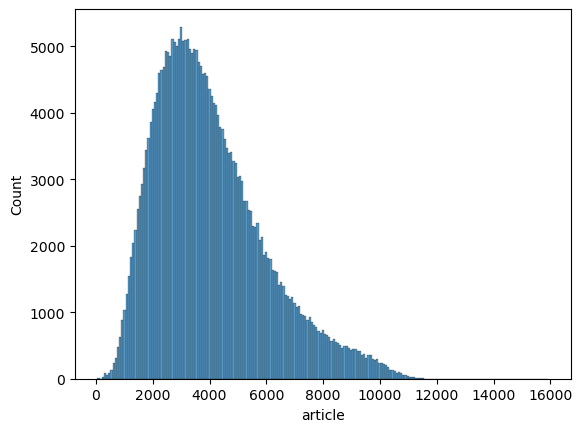

In [8]:
sns.histplot(x=df_train.article.apply(lambda x: len(x)));

there is very little around 0, I would like to check later that these numbers are not too low, and see if they are valid articles (maybe below 30)
we also have a long tail with a very high number of charters, and a very low number of samples in that area (above 12000)
Overall it is lightly right-skewed normally distributed, as expected.

let's see that number of words in each article is distributed in the same way:

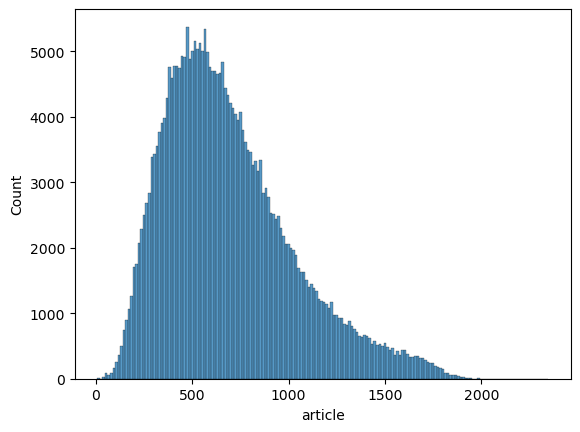

In [9]:
sns.histplot(x=df_train.article.apply(lambda x: len(x.split())));


Looks good.

In [10]:
df_test = pd.read_csv('sub_test.csv')
df_test.head(1)

,id,article,highlights
0,e9006139909df25f212ba8d7713bd7688e0aca74,"Ronan Ghosh, 39, stole £200 worth of meat and ...","Ronan Ghosh, 39, was shopping at Tesco store i..."


## preprosseing

First we will tokenizing each artical into sentences

In [4]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

artical = str(df_train.iloc[0, 0])
sentences = sent_tokenize(artical)
sentences

['0001d1afc246a7964130f43ae940af6bc6c57f01']

## Models

### Random Model

This model takes randomly some sentences in the text to create the summary.



In [5]:
class RandomModel:
    def summarize(self, articles, threshold=0.2):
        result = []
        for article in articles:
            sentence_tokenized = sent_tokenize(article)
            num_sentences = int(threshold*len(sentence_tokenized))
            index_sentences_summary = np.sort(np.random.choice(len(sentence_tokenized), 
                                                               num_sentences, 
                                                               replace=False))
            summary = " ".join(list(np.array(sentence_tokenized)[index_sentences_summary]))
            result.append(summary)
        return result

In [6]:
rm = RandomModel()
summaries = rm.summarize(df_train["article"].values)



In [7]:

random_summaries = summaries
random_summaries[0]

'PUBLISHED: . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. Fargo Catholic Diocese in North Dakota (pictured) is where the bishop is located .'

In [8]:
random_val_summaries = rm.summarize(df_val["article"].values)

In [11]:
random_test_summaries = rm.summarize(df_test["article"].values)

### Weight Sentences Model

In [16]:
class WeightedModel:
    def create_dictionary_table(self, text_string) -> dict:
        # Removing stop words
        stop_words = set(stopwords.words("english"))
        
        words = word_tokenize(text_string)
        
        # Reducing words to their root form
        stem = PorterStemmer()
        
        # Creating dictionary for the word frequency table
        frequency_table = dict()
        for wd in words:
            wd = stem.stem(wd)
            if wd in stop_words:
                continue
            if wd in frequency_table:
                frequency_table[wd] += 1
            else:
                frequency_table[wd] = 1

        return frequency_table
    
    def calculate_weight(self, sentence, frequency_table):
        # the weight of a sentence is the sum of all the frequency of the words in it, divided by the lentgh of the sentence (num of words)
        words = word_tokenize(sentence)

        stem = PorterStemmer()

        weight = 0
        for wd in words:
            wd = stem.stem(wd)
            if wd not in frequency_table.keys():
                continue
            weight += frequency_table[wd]
        
        return weight/len(words)

    def summarize(self, articals, num_of_sentences=2):
        result = []
        for artical in articals:
            frequency_table = self.create_dictionary_table(artical)
            sentence_tokenized = sent_tokenize(artical)
            weights = [self.calculate_weight(sentence, frequency_table) for sentence in sentence_tokenized]
            idxs = np.argsort(weights)
            summary = " ".join(list(np.array(sentence_tokenized)[idxs[:num_of_sentences]]))
            result.append(summary)
        return result


In [17]:
weight_m = WeightedModel()

In [ ]:
sub_df_train = df_train.sample(100)

# summaries = weight_m.summarize(df_train.article.values)
# summaries_df = pd.DataFrame({'id': df_train.id, 'summary': summaries})
# summaries_df.to_csv('summaries by sentences weights.csv')
# summaries_df

summaries_df = pd.read_csv('summaries by sentences weights.csv')
summaries = summaries_df.summary.values


In [ ]:
df_val.shape

(13368, 3)

In [ ]:
val_summaries = weight_m.summarize(df_val.article.values)
val_summaries_df = pd.DataFrame({'id': df_val.id, 'summary': val_summaries})
val_summaries_df.to_csv('validation summaries by sentences weights.csv')
val_summaries_df

,id,summary
0,61df4979ac5fcc2b71be46ed6fe5a46ce7f071c3,She also starred in a Broadway production of T...
1,21c0bd69b7e7df285c3d1b1cf56d4da925980a68,'By drawing what I see I become far more a par...
2,56f340189cd128194b2e7cb8c26bb900e3a848b4,She broke up with him when her Hindu parents a...
3,00a665151b89a53e5a08a389df8334f4106494c2,His brother Prince William is also a fan and e...
4,9f6fbd3c497c4d28879bebebea220884f03eb41a,'The Producers had a few drinks on Friday & Ha...
...,...,...
13363,e93f721ba4949f21f33549c4a21d55ff456af979,Ministers also want to make it easier for a ba...
13364,8df19a570ad14119a7d00f3bbe864fedf8c1691d,The GB Team runner takes a tumble after crossi...
13365,2fdd5f89aa26e91ceea9b0ef264abfcfc3e6fa2e,Matt Doherty wriggled free on the right and cr...
13366,530d7b18d7a715b368b0745f9dfebfe353adeda8,For confidential support on suicide matters ca...


In [18]:
test_summaries = weight_m.summarize(df_test.article.values)

# Model Evaluation

In [ ]:
def evaluate_similarity(true_summary, pred_summary):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([true_summary, pred_summary])
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)[0, 1]
    return cosine_sim


In [ ]:
def calculate_all_similarities(true_summaries, pred_summaries):
    assert len(true_summaries) == len(pred_summaries)
    similarities = []
    for true_summary, pred_summary in zip(true_summaries, pred_summaries):
        similarities.append(evaluate_similarity(true_summary, pred_summary))
    return similarities

### Weighted Sentenced

In [ ]:
train_scores = calculate_all_similarities(df_train['highlights'].values, summaries)
val_scores = calculate_all_similarities(df_val['highlights'].values, val_summaries)


In [ ]:
print(f'Average score on train set: {np.mean(train_scores):.2}')
print(f'Average score on validation set: {np.mean(val_scores):.2}')
print(f'Scores variance on train set: {np.var(train_scores):.2}')
print(f'Scores variance on validation set: {np.var(val_scores):.2}')



Average score on train set: 0.19
Average score on validation set: 0.2
Scores variance on train set: 0.012
Scores variance on validation set: 0.012


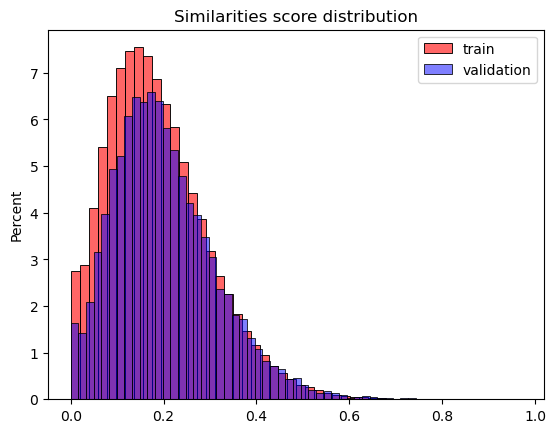

In [ ]:
sns.histplot(x=train_scores, color = 'red', stat='percent', alpha=0.6, bins=50, label='train')
sns.histplot(x=val_scores, color='blue', stat='percent', alpha=0.5, bins=50, label='validation')
plt.title('Similarities score distribution')
plt.legend();


### Random Model

In [ ]:
train_random_scores = calculate_all_similarities(df_train['highlights'].values, random_summaries)
val_random_scores = calculate_all_similarities(df_val['highlights'].values, random_val_summaries)


In [ ]:
print(f'Average score on train set: {np.mean(train_random_scores):.2}')
print(f'Average score on validation set: {np.mean(val_random_scores):.2}')
print(f'Scores variance on train set: {np.var(train_random_scores):.2}')
print(f'Scores variance on validation set: {np.var(val_random_scores):.2}')



Average score on train set: 0.29
Average score on validation set: 0.32
Scores variance on train set: 0.015
Scores variance on validation set: 0.016


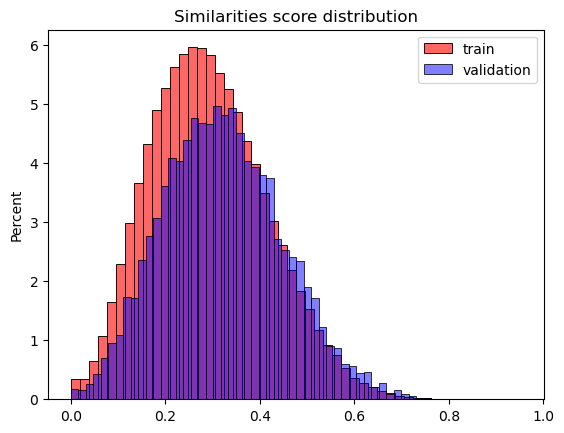

In [ ]:
sns.histplot(x=train_random_scores, color = 'red', stat='percent', alpha=0.6, bins=50, label='train')
sns.histplot(x=val_random_scores, color='blue', stat='percent', alpha=0.5, bins=50, label='validation')
plt.title('Similarities score distribution')
plt.legend();

### BLEU score

In [20]:
bleu = evaluate.load("bleu")
references =[[highlight] for highlight in df_test['highlights'].values]

#### Random

In [21]:

bleu.compute(predictions=random_test_summaries, references=references)


{'bleu': 0.049900276809892716,
 'precisions': [0.18875296458358864,
  0.05733973265177204,
  0.029745840190162735,
  0.0192591064481905],
 'brevity_penalty': 1.0,
 'length_ratio': 2.4154797144349645,
 'translation_length': 138721,
 'reference_length': 57430}

##### Weighted Sentenced

In [22]:
bleu.compute(predictions=test_summaries, references=references)



{'bleu': 0.04076284619092154,
 'precisions': [0.23508644012510313,
  0.04804663810474011,
  0.023564858231737734,
  0.01559541502941955],
 'brevity_penalty': 0.9030803904217664,
 'length_ratio': 0.907487375935922,
 'translation_length': 52117,
 'reference_length': 57430}